In [3]:
!pip install contractions
!pip install fastcluster

     |████████████████████████████████| 245kB 4.1MB/s 
     |████████████████████████████████| 317kB 53.5MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81691 sha256=a28291ddcd19f677e85d91acd1097b1f023ab6504d4a99bce5753ad7deb7a352
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick
     |████████████████████████████████| 163kB 2.8MB/s 


In [4]:
# General
import os
import re
import sklearn
import nltk
import numpy as np
import pandas as pd
import contractions
import glob
# Preprocessing
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
# models
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet
from scipy.spatial.distance import pdist
# Plots
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn
import seaborn as sns
# Enable inline plotting  
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
subject_dirs = glob.glob('*.csv')

In [6]:
df = []
for file in subject_dirs:
    try:
        df.append(pd.read_csv(file,engine='python'))
    except Exception as e:
        print('error {} happened for file {}'.format(e,file))
    
data = pd.concat(df,axis=0)
data = shuffle(data)
data.index = range(len(data))

error Expected 21 fields in line 289, saw 1541 happened for file energy15.csv
error Expected 21 fields in line 100, saw 321 happened for file energy16.csv


In [7]:
len(data)

127636

In [8]:
data.columns

Index(['id', 'author', 'authorLink', 'authorThumb', 'text', 'likes', 'time',
       'timestamp', 'edited', 'hasReplies', 'repliesToken', 'numReplies',
       'reply.id', 'reply.author', 'reply.authorLink', 'reply.authorThumb',
       'reply.text', 'reply.likes', 'reply.time', 'reply.timestamp',
       'reply.edited'],
      dtype='object')

In [9]:
data.head()

,id,author,authorLink,authorThumb,text,likes,time,timestamp,edited,hasReplies,repliesToken,numReplies,reply.id,reply.author,reply.authorLink,reply.authorThumb,reply.text,reply.likes,reply.time,reply.timestamp,reply.edited
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UgwcV10-rehXsxbFbuJ4AaABAg.8tEVd67ozuA8uD3imImvIy,Deep Modi,/channel/UC_tDqJ9HgAwQBoymSZE7R-g,https://yt3.ggpht.com/a/AATXAJzbx40ZR4YVLzuG4a...,@ZeeZee Zputnik m talking abouth the britishers,0.0,10 months ago,1.558293e+12,False
1,UgwZt3v8AB7xgo1__094AaABAg,gp g,/channel/UCdyrgMTy3gzm_9W4XjIWiXQ,https://yt3.ggpht.com/a/AATXAJzq5fXLKLaMP_wTaO...,"Wat about russia , brazil, , rest green south ...",0.0,1 month ago,1.582144e+12,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,UgzhL4q_Nh-l5vRTEg54AaABAg,Mike Rock,/channel/UCSJiN1HfaeTe8PcsyFLhqjA,https://yt3.ggpht.com/a/AATXAJy-rBCbwg7tx13dOO...,Us needs to get the ass in gear an go green,14.0,1 year ago,1.553008e+12,False,True,EkQSC3NrMG1ZSEhXbFlrwAEAyAEA4AEBogINKP________...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UgwsHsIzIQ2jJzrACOF4AaABAg.8kLpDOpWMnK8lapvDnUl6K,Nemesis Rockwell,/channel/UCifxl5bmqtZNfMrhxwQ0PVA,https://yt3.ggpht.com/a/AATXAJxc6ATxIP_2mwcbK7...,Christians make me sick,3.0,1 year ago,1.553011e+12,False
4,Ugzcj47jTcEMLfvE1X14AaABAg,Roshan shyalia,/channel/UCIk7Xaw0lycYkUT8VWY1gzg,https://yt3.ggpht.com/a/AATXAJzr39ob2yNw8gjXkz...,abb koi nhi pehchan skda jamuna koi puri clean ha,0.0,7 months ago,1.566230e+12,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data = data[~(data['text'].isnull() & data['reply.text'].isnull())]

In [11]:
len(data)

127636

In [ ]:
data['text_merged'] = data['text'].astype(str)+data['reply.text'].astype(str)

In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stopword = stopwords.words('english') 

In [ ]:
def stemming(words):
    ps = nltk.stem.SnowballStemmer('english')
    new = []
    stem_words = [ps.stem(x) for x in words]
    return stem_words

In [ ]:
def preprocess(sentence):
    sentence = contractions.fix(sentence)             # Replace contractions in string 
    sentence = re.sub('@\w+',"",str(sentence))        # remove mentions
    sentence = re.sub('#\w+',"",str(sentence))        # remove hashtags
    sentence = re.sub('http\S+',"",str(sentence))     # remove URLs
    sentence = re.sub('[^\w\s]'," ",str(sentence))    # remove punc
    sentence = re.sub('[^a-zA-Z]'," ",str(sentence))  # remove numbers
  
    sents = word_tokenize(sentence)                   # Tokenization
    sents = stemming(sents)
            
    new_sents = ""
    for i in range(len(sents)):                       # remove stopwords            
        if(sents[i].lower() not in stopword and sents[i]!='rt' and len(sents[i])>3):
            new_sents += sents[i].lower()+" "
    new_sents.strip()
    
    return new_sents

In [ ]:
def preprocessing(xtrain):
    corpus = xtrain.apply(preprocess)
    return corpus

In [18]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
corpus = preprocessing(data['text_merged'])
corpus = corpus.drop_duplicates() 

In [ ]:
def featureextraction(corpus):
    
    vectorizer = TfidfVectorizer(max_df=.5,min_df=1,max_features=None,ngram_range=(1, 2),norm=None,binary=True,
                             use_idf=False,sublinear_tf=False,strip_accents = 'unicode',stop_words = 'english')
    vectorizer = vectorizer.fit(corpus)
    tfidf = vectorizer.transform(corpus)
    vocab = vectorizer.get_feature_names()

    return tfidf, vocab

In [ ]:
tfidf, vocab = featureextraction(corpus)

In [22]:
np.shape(tfidf)

(111733, 585605)

In [ ]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
svd = TruncatedSVD(n_components=50)

In [ ]:
sv = svd.fit_transform(tfidf)

In [26]:
np.shape(sv)

(111733, 50)

In [ ]:
Z = fastcluster.linkage_vector(sv,method='ward', metric='euclidean')

In [ ]:
Z_dataFrame = pd.DataFrame(data=Z, 
    columns=['clusterOne','clusterTwo','distance','newClusterSize']) 

In [29]:
Z

array([[1.27000000e+02, 3.10000000e+02, 0.00000000e+00, 2.00000000e+00],
       [8.20200000e+03, 2.82550000e+04, 0.00000000e+00, 2.00000000e+00],
       [2.05200000e+03, 8.97470000e+04, 0.00000000e+00, 2.00000000e+00],
       ...,
       [2.23457000e+05, 2.23460000e+05, 8.67829686e+01, 7.09260000e+04],
       [2.23461000e+05, 2.23462000e+05, 9.60882137e+01, 7.26790000e+04],
       [2.23420000e+05, 2.23463000e+05, 1.14368351e+02, 1.11733000e+05]])

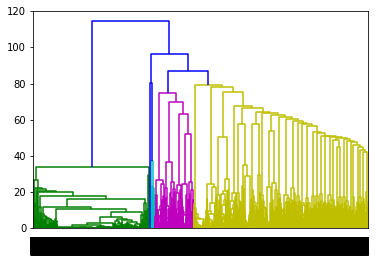

In [30]:
dend = dendrogram(Z)

In [ ]:
from scipy.cluster.hierarchy import fcluster

distance_threshold = 100
clusters = fcluster(Z, distance_threshold, criterion='distance')

In [ ]:
from collections import Counter

In [52]:
Counter(clusters)

Counter({1: 39054, 2: 72679})

In [53]:
len(clusters)

111733

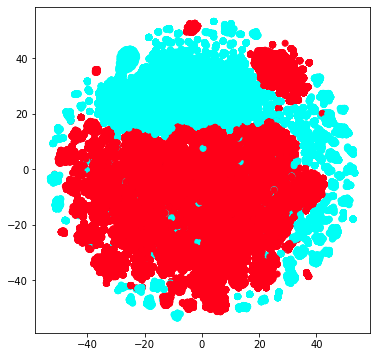

In [65]:
f, ax = plt.subplots(1, 1, figsize=(6, 6))
tsne = TSNE(n_components=2).fit_transform(sv)
max_label = max(clusters)
label_subset = [cm.hsv(i/max_label) for i in clusters]
ax.scatter(tsne[:, 0], tsne[:, 1], c=label_subset)

In [ ]:
dic = {i:np.zeros((1,np.shape(tfidf)[1])) for i in range(1,max(clusters)+1)}
count = {i:0 for i in range(1,max(clusters)+1)}

In [ ]:
for i,x in enumerate(tfidf):
  count[clusters[i]] += 1
  dic[clusters[i]] = np.sum([dic[clusters[i]],x.toarray()],axis=0)

In [56]:
for key in dic.keys():
    print(np.shape(dic[key]))

(1, 585605)
(1, 585605)


In [ ]:
dic = {i:np.divide(dic[i],count[i]) for i in range(1,max(clusters)+1)}

In [ ]:
dic1 = {i:dic[i][0] for i in range(1,max(clusters)+1)}

In [ ]:
df = pd.DataFrame.from_dict(dic1, orient='index',columns=range(np.shape(tfidf)[1]))

In [60]:
np.shape(df)

(2, 585605)

In [61]:
len(vocab)

585605

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def get_top_keywords(df, labels, n_terms):
    df.columns = labels

    for i,r in df.iterrows():
        label_new = list(df.columns[np.argsort(df.iloc[i-1])])
        dd = pd.DataFrame([np.argsort(df.iloc[i-1])],columns=label_new)
        wordcloud = WordCloud(background_color = 'white')
        wordCloud = wordcloud.generate_from_frequencies(dd.iloc[0,-200:])
        plt.figure(figsize=(8, 8))
        plt.imshow(wordCloud)
        plt.axis("off")
        
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))


Cluster 1
great,british,realli,stupid,nanit,indianan,true,pleas,mean,nahi,nani,delhi,human,everi,modi,love,thank,religion,place,bhai

Cluster 2
live,video,problem,shit,know,need,onli,think,make,becaus,world,clean,water,pollut,river,like,countri,indian,peopl,india


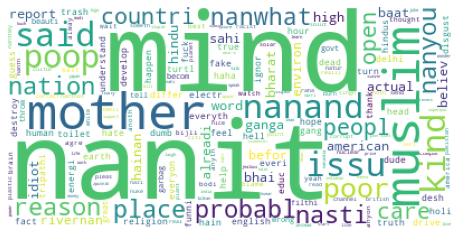

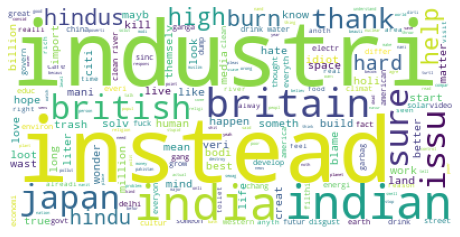

In [64]:
get_top_keywords(df, vocab, 20)